In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from scipy import signal
from scipy.stats import boxcox
import warnings
warnings.filterwarnings('ignore')

# Code Base

## Calculate Technical Indicators

In [2]:
def calculate_technical_indicators(df):
    """
    Calculate comprehensive technical indicators from OHLC data
    """
    df = df.copy()

    # Moving Averages
    windows = [5, 10, 15, 20, 30, 50]
    for window in windows:
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'EMA_{window}'] = df['Close'].ewm(span=window).mean()

    # Bollinger Bands
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = rolling_mean + (rolling_std * 2)
    df['BB_Lower'] = rolling_mean - (rolling_std * 2)
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / df['BB_Width']

    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # Stochastic Oscillator
    high_14 = df['High'].rolling(window=14).max()
    low_14 = df['Low'].rolling(window=14).min()
    df['%K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    df['%D'] = df['%K'].rolling(window=3).mean()

    # Average True Range (ATR)
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df['ATR'] = true_range.rolling(14).mean()

    return df


## Other Statistics based features

In [3]:
def calculate_statistical_features(df):
    """
    Calculate advanced statistical features
    """
    # Rolling statistics
    # for window in [5, 10, 20]:
    #     df[f'Skewness_{window}'] = df['Returns'].rolling(window=window).skew()
    #     df[f'Kurtosis_{window}'] = df['Returns'].rolling(window=window).kurt()
    #     df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()

    # Z-scores for normalization
    df['Close_ZScore_20'] = (df['Close'] - df['Close'].rolling(20).mean()) / df['Close'].rolling(20).std()

    # Momentum indicators
    df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1

    return df


## Preprocessing Function

In [4]:
class AdvancedPreprocessingPipeline:
    def __init__(self):
        self.scalers = {}

    def stationarity_test(self, series):
        from statsmodels.tsa.stattools import adfuller, kpss

        # ADF Test
        adf_result = adfuller(series.dropna())
        adf_stationary = adf_result[1] < 0.05

        # KPSS Test
        kpss_result = kpss(series.dropna())
        kpss_stationary = kpss_result[1] > 0.05

        return {
            'adf_stationary': adf_stationary,
            'kpss_stationary': kpss_stationary,
            'is_stationary': adf_stationary and kpss_stationary
        }

    def make_stationary(self, df):
        # Apply differencing if needed
        for col in ['Close', 'Open', 'High', 'Low']:
            if col in df.columns:
                stationarity = self.stationarity_test(df[col])
                if not stationarity['is_stationary']:
                    df[f'{col}_diff'] = df[col].diff()
        return df

    def feature_scaling(self, X_train, X_test, method='robust'):
        from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()

        for col in X_train.columns:
            if method == 'minmax':
                scaler = MinMaxScaler()
            elif method == 'standard':
                scaler = StandardScaler()
            else:  # robust
                scaler = RobustScaler()

            X_train_scaled[col] = scaler.fit_transform(X_train[[col]])
            X_test_scaled[col] = scaler.transform(X_test[[col]])
            self.scalers[col] = scaler

        return X_train_scaled, X_test_scaled


## Models

### Tree Based Models

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

class TreeBasedPredictor:
    def __init__(self):
        self.model = RandomForestRegressor(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose = 1
        )

    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        print("Trainig Tree")
        # Feature importance analysis
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        return feature_importance

    def predict(self, X_test):
        return self.model.predict(X_test)

    def predict_with_uncertainty(self, X_test):
        # Get predictions from all trees
        predictions = np.array([tree.predict(X_test) for tree in self.model.estimators_])
        return np.mean(predictions, axis=0), np.std(predictions, axis=0)


### XG Boost Model

In [6]:
class GradientBoostingPredictor:
    def __init__(self):
        self.model = xgb.XGBRegressor(
            objective='reg:squarederror',  # Explicitly set objective for regression
            n_estimators=2000,  # Increased estimators
            max_depth=10,       # Increased depth
            learning_rate=0.005, # Decreased learning rate
            subsample=0.9,      # Adjusted subsample
            colsample_bytree=0.9, # Adjusted colsample
            reg_alpha=0.2,      # Adjusted L1 regularization
            reg_lambda=0.2,      # Adjusted L2 regularization
            gamma=0.1,          # Added minimum loss reduction
            min_child_weight=1, # Added minimum sum of instance weight needed in a child
            random_state=42,
            early_stopping_rounds=75, # Adjusted early stopping
            eval_metric='rmse'
        )

    def train(self, X_train, y_train, X_val=None, y_val=None):
        if X_val is not None and y_val is not None:
            eval_set = [(X_train, y_train), (X_val, y_val)]
            self.model.fit(
                X_train, y_train,
                eval_set=eval_set,
                verbose=1
            )
        else:
            self.model.fit(X_train, y_train)

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        return feature_importance

    def predict(self, X_test):
        return self.model.predict(X_test)



### Deep Learning Model

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class LSTMPredictor:
    def __init__(self, sequence_length=60, n_features=None):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.model = None

    def create_sequences(self, data, target_col='Close'):
        X, y = [], []
        for i in range(self.sequence_length, len(data)):
            X.append(data[i-self.sequence_length:i].values)
            y.append(data[target_col].iloc[i])
        return np.array(X), np.array(y)

    def build_model(self):
        self.model = Sequential([
            LSTM(128, return_sequences=True, input_shape=(self.sequence_length, self.n_features)),
            Dropout(0.2),
            BatchNormalization(),

            LSTM(128, return_sequences=True),
            Dropout(0.2),
            BatchNormalization(),

            LSTM(64, return_sequences=False),
            Dropout(0.2),
            BatchNormalization(),

            Dense(50, activation='relu'),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])

        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mse']
        )

        return self.model

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100):
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
        ]

        validation_data = (X_val, y_val) if X_val is not None else None

        history = self.model.fit(
            X_train, y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=32,
            callbacks=callbacks,
            verbose=1
        )

        return history

    def predict(self, X_test):
        return self.model.predict(X_test)


### Reinforcement Learning Models

In [9]:
import numpy as np
from collections import deque
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

class TradingEnvironment:
    def __init__(self, data, initial_balance=100000):
        self.data = data
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_profit = 0
        return self.get_state()

    def get_state(self):
        if self.current_step >= len(self.data):
            return None

        row = self.data.iloc[self.current_step]
        state = np.array([
            row['Close'] / 10000,  # Normalized price
            row['Volume'] / 1000000,  # Normalized volume
            row['RSI'] / 100,  # RSI
            row['MACD'],  # MACD
            self.balance / self.initial_balance,  # Normalized balance
            self.shares_held / 1000,  # Normalized shares
        ])
        return state

    def step(self, action):
        if self.current_step >= len(self.data) - 1:
            return None, 0, True, {}

        current_price = self.data.iloc[self.current_step]['Close']

        # Actions: 0=Hold, 1=Buy, 2=Sell
        reward = 0

        if action == 1:  # Buy
            shares_to_buy = self.balance // current_price
            if shares_to_buy > 0:
                self.shares_held += shares_to_buy
                self.balance -= shares_to_buy * current_price

        elif action == 2 and self.shares_held > 0:  # Sell
            self.balance += self.shares_held * current_price
            reward = self.shares_held * current_price
            self.shares_held = 0

        self.current_step += 1
        next_state = self.get_state()

        # Calculate reward based on portfolio value change
        portfolio_value = self.balance + self.shares_held * current_price
        reward = (portfolio_value - self.initial_balance) / self.initial_balance

        done = self.current_step >= len(self.data) - 1

        return next_state, reward, done, {}

class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = lr
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(64, input_dim=self.state_size, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state.reshape(1, -1))
        return np.argmax(q_values[0])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return

        batch = random.sample(self.memory, batch_size)
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])

        target = rewards + 0.95 * np.amax(self.model.predict(next_states), axis=1) * (1 - dones)
        target_full = self.model.predict(states)
        target_full[np.arange(batch_size), actions] = target

        self.model.fit(states, target_full, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


### Ensemble Models

In [10]:
class EnsemblePredictor:
    def __init__(self, models, weights=None):
        self.models = models
        self.weights = weights or [1/len(models)] * len(models)

    def train_all(self, X_train, y_train, X_val=None, y_val=None):
        self.trained_models = []
        for model in self.models:
            if hasattr(model, 'train'):
                model.train(X_train, y_train, X_val, y_val)
            else:
                model.fit(X_train, y_train)
            self.trained_models.append(model)

    def predict(self, X_test):
        predictions = []
        for model in self.trained_models:
            if hasattr(model, 'predict'):
                pred = model.predict(X_test)
            else:
                pred = model.predict(X_test)
            predictions.append(pred)

        # Weighted average
        ensemble_pred = np.average(predictions, axis=0, weights=self.weights)
        return ensemble_pred

    def predict_with_confidence(self, X_test):
        predictions = []
        for model in self.trained_models:
            pred = model.predict(X_test)
            predictions.append(pred)

        ensemble_pred = np.average(predictions, axis=0, weights=self.weights)
        ensemble_std = np.std(predictions, axis=0)

        return ensemble_pred, ensemble_std

# Pipeline

In [ ]:
import pandas as pd

# Load your minute-wise NIFTY 50 data
df = pd.read_csv('NIFTY 50_minute_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Ensure proper column names
required_columns = ['Open', 'High', 'Low', 'Close']
assert all(col in df.columns for col in required_columns)


In [36]:
df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-02-07 15:25:00,23569.45,23570.60,23567.00,23568.10,0
2025-02-07 15:26:00,23568.10,23570.25,23565.30,23567.40,0
2025-02-07 15:27:00,23569.00,23578.35,23565.40,23576.50,0
2025-02-07 15:28:00,23577.05,23578.60,23567.45,23568.10,0
2025-02-07 15:29:00,23568.10,23571.35,23557.35,23563.15,0


In [37]:
start_date = pd.to_datetime('2024-01-07')
end_date = pd.to_datetime('2025-02-07')

df = df[(df.index >= start_date) & (df.index <= end_date)].copy()

print(df.head())
print(df.tail())
print(len(df))


                         Open     High       Low     Close  Volume
Date                                                              
2024-01-08 09:15:00  21747.60  21754.2  21706.70  21732.40       0
2024-01-08 09:16:00  21730.15  21745.8  21730.05  21737.80       0
2024-01-08 09:17:00  21735.65  21742.3  21735.30  21740.50       0
2024-01-08 09:18:00  21740.55  21745.5  21735.45  21737.30       0
2024-01-08 09:19:00  21738.70  21741.8  21735.75  21738.75       0
                         Open      High       Low     Close  Volume
Date                                                               
2025-02-06 15:25:00  23616.85  23623.35  23615.65  23620.75       0
2025-02-06 15:26:00  23620.20  23621.75  23614.20  23616.15       0
2025-02-06 15:27:00  23614.55  23629.40  23612.20  23626.65       0
2025-02-06 15:28:00  23627.45  23628.45  23620.95  23627.95       0
2025-02-06 15:29:00  23626.00  23633.70  23622.70  23628.05       0
101139


In [38]:
# Apply comprehensive feature engineering
df_processed = calculate_technical_indicators(df)

df_processed = calculate_statistical_features(df_processed)

# Create target variable (15 minutes ahead)
df_processed['Target_15min'] = df_processed['Close'].shift(-15)

# Remove missing values
df_processed = df_processed.dropna()
df_processed.tail()

,Open,High,Low,Close,Volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_15,...,MACD,MACD_Signal,MACD_Histogram,%K,%D,ATR,Close_ZScore_20,Momentum_5,Momentum_10,Target_15min
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-06 15:10:00,23607.70,23608.60,23603.50,23605.00,0,23606.65,23605.121845,23601.710,23600.662770,23593.836667,...,8.754527,6.764486,1.990041,85.840708,90.219470,7.589286,1.114768,-0.000011,0.001039,23620.75
2025-02-06 15:11:00,23605.20,23605.60,23596.80,23598.15,0,23604.42,23602.797897,23603.175,23600.205903,23595.210000,...,8.051545,7.021898,1.029647,68.520860,82.132322,7.635714,0.577786,-0.000472,0.000621,23616.15
2025-02-06 15:12:00,23598.15,23600.10,23595.50,23595.50,0,23602.72,23600.365265,23603.180,23599.350284,23596.523333,...,7.197624,7.057043,0.140581,57.404795,70.588788,7.403571,0.322822,-0.000360,0.000002,23626.65
2025-02-06 15:13:00,23595.70,23596.85,23587.00,23588.40,0,23598.90,23596.376843,23602.430,23597.359323,23597.373333,...,5.880191,6.821673,-0.941481,31.162791,52.362815,7.571429,-0.263161,-0.000809,-0.000318,23627.95
2025-02-06 15:14:00,23587.90,23595.90,23587.45,23595.70,0,23596.55,23596.151229,23601.625,23597.057628,23598.356667,...,5.363340,6.530006,-1.166666,51.227496,46.598361,7.292857,0.219931,-0.000498,-0.000341,23628.05


In [39]:
# Time-based split
train_size = int(len(df_processed) * 0.8)
train_data = df_processed.iloc[:train_size]
test_data = df_processed.iloc[train_size:]

# Separate features and target
feature_cols = [col for col in df_processed.columns if col not in ['Target_15min', 'Open', 'High', 'Low']]
X_train, y_train = train_data[feature_cols], train_data['Target_15min']
X_test, y_test = test_data[feature_cols], test_data['Target_15min']
print(len(X_test) , len(y_test))

20215 20215


In [40]:
print(feature_cols)

['Close', 'Volume', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'SMA_50', 'EMA_50', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram', '%K', '%D', 'ATR', 'Close_ZScore_20', 'Momentum_5', 'Momentum_10']


In [ ]:
# Initialize the LSTM predictor
sequence_length = 60
n_features = len(feature_cols)
lstm_predictor = LSTMPredictor(sequence_length=sequence_length, n_features=n_features , feature_cols = feature_cols)

# Normalize data and create sequences
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = lstm_predictor.normalize_features_and_target(train_data, test_data)

# Print shapes to verify
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of y_train_lstm:", y_train_lstm.shape)
print("Shape of X_test_lstm:", X_test_lstm.shape)
print("Shape of y_test_lstm:", y_test_lstm.shape)

# Now you can build and train the model using X_train_lstm and y_train_lstm
model = lstm_predictor.build_model()
history = lstm_predictor.train(X_train_lstm, y_train_lstm, epochs=50) # Add validation split if needed

# To get original predictions back:
predictions_scaled = lstm_predictor.predict(X_test_lstm)
predictions_original = lstm_predictor.inverse_transform_y(predictions_scaled)
y_test_original = lstm_predictor.inverse_transform_y(y_test_lstm) # Inverse transform the test target as well


Shape of X_train_lstm: (80800, 60, 28)
Shape of y_train_lstm: (80800,)
Shape of X_test_lstm: (20155, 60, 28)
Shape of y_test_lstm: (20155,)
Epoch 1/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0413 - mse: 0.0413 - learning_rate: 0.0010
Epoch 2/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0030 - mse: 0.0030 - learning_rate: 0.0010
Epoch 3/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.0021 - mse: 0.0021 - learning_rate: 0.0010
Epoch 4/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0015 - mse: 0.0015 - learning_rate: 0.0010
Epoch 5/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0019 - mse: 0.0019 - learning_rate: 0.0010
Epoch 6/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0013 - mse: 0.0013 - learning_rate: 0.0010
Epoch 7/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.0014 - mse: 0.0014 - learning_rate: 0.0010
Epoch 8/50
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 5.5822e-04 - mse: 5.5822e-04 - le

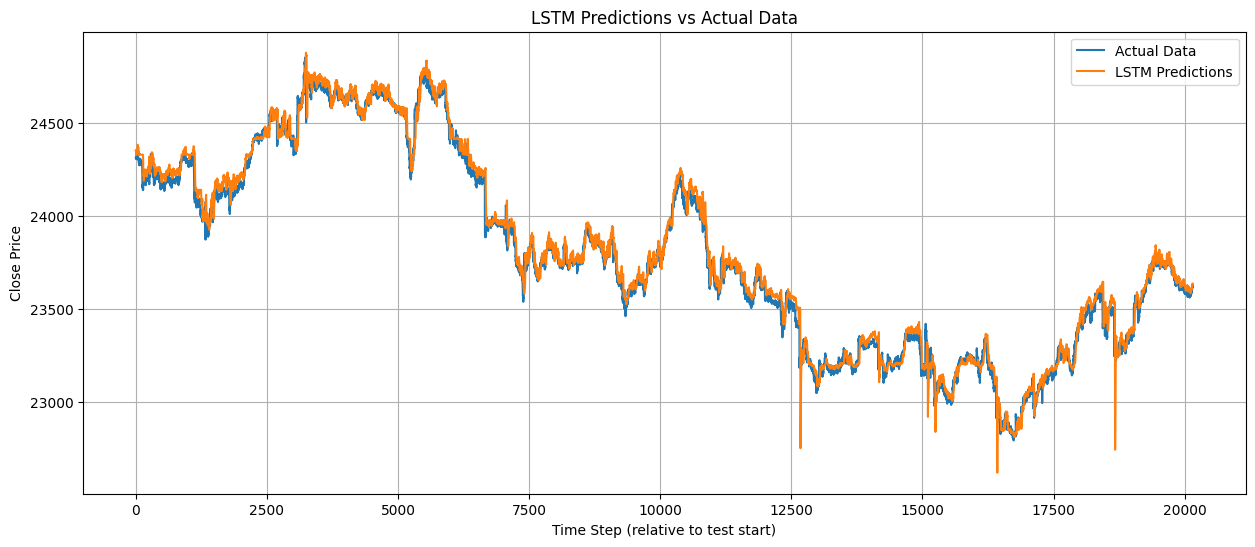

In [43]:
import matplotlib.pyplot as plt
# Ensure the lengths match before plotting
min_len = min(len(y_test_original), len(predictions_original))

plt.figure(figsize=(15, 6))
plt.plot(y_test_original[:min_len], label='Actual Data')
plt.plot(predictions_original[:min_len], label='LSTM Predictions')
plt.title('LSTM Predictions vs Actual Data')
plt.xlabel('Time Step (relative to test start)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Initialize models
rf_model = TreeBasedPredictor()
xgb_model = GradientBoostingPredictor()

In [ ]:
# Initialize models
rf_model = TreeBasedPredictor()
xgb_model = GradientBoostingPredictor()

# Split the training data into training and validation sets
# Using 80% of the original training data for training and 20% for validation
train_size_xgb = int(len(X_train) * 0.8)
X_train_xgb, X_val_xgb = X_train.iloc[:train_size_xgb], X_train.iloc[train_size_xgb:]
y_train_xgb, y_val_xgb = y_train.iloc[:train_size_xgb], y_train.iloc[train_size_xgb:]


# Train models
# rf_model.train(X_train, y_train)
xgb_model.train(X_train_xgb, y_train_xgb, X_val=X_val_xgb, y_val=y_val_xgb)

[0]	validation_0-rmse:1697.86964	validation_1-rmse:4323.36490
[1]	validation_0-rmse:1689.38438	validation_1-rmse:4309.62146
[2]	validation_0-rmse:1680.94174	validation_1-rmse:4295.88249
[3]	validation_0-rmse:1672.54141	validation_1-rmse:4282.28110
[4]	validation_0-rmse:1664.18249	validation_1-rmse:4268.67344
[5]	validation_0-rmse:1655.86589	validation_1-rmse:4255.13838
[6]	validation_0-rmse:1647.59067	validation_1-rmse:4241.67401
[7]	validation_0-rmse:1639.35686	validation_1-rmse:4228.27321
[8]	validation_0-rmse:1631.16423	validation_1-rmse:4214.95148
[9]	validation_0-rmse:1623.01242	validation_1-rmse:4201.68709
[10]	validation_0-rmse:1614.90166	validation_1-rmse:4188.55983
[11]	validation_0-rmse:1606.83131	validation_1-rmse:4175.43431
[12]	validation_0-rmse:1598.80126	validation_1-rmse:4162.38070
[13]	validation_0-rmse:1590.81171	validation_1-rmse:4149.28544
[14]	validation_0-rmse:1582.86171	validation_1-rmse:4136.24905
[15]	validation_0-rmse:1574.95149	validation_1-rmse:4123.38288
[1

,feature,importance
9,EMA_20,0.430608
10,SMA_30,0.153499
13,EMA_50,0.115287
2,SMA_5,0.094641
11,EMA_30,0.075966
14,BB_Upper,0.040716
0,Close,0.030634
12,SMA_50,0.021400
3,EMA_5,0.012102
7,EMA_15,0.008615


In [ ]:
rf_model.train(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.6min


Trainig Tree


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.6min finished


,feature,importance
0,Close,0.151159
2,SMA_5,0.137291
5,EMA_10,0.105109
3,EMA_5,0.095201
7,EMA_15,0.093284
9,EMA_20,0.069238
6,SMA_15,0.067154
14,BB_Upper,0.048432
4,SMA_10,0.047973
10,SMA_30,0.043793


In [32]:
print(len(X_test) , len(y_test))

1788 1788


In [ ]:
# Get predictions for next 15 minutes
# latest_data = X_test.iloc[-1:].copy()

rf_pred = rf_model.predict(X_test)

xg_pred = xgb_model.predict(X_test)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.5s finished


In [ ]:
print(rf_pred)
print(xg_pred)

[25388.73844225 25387.84129744 25386.48911063 ... 23590.55799748
 23589.1160323  23589.3290625 ]
[22740.83  22742.645 22745.092 ... 22828.916 22808.803 22804.951]


In [33]:
rmse = np.sqrt(mean_squared_error(y_test, predictions_original))
print(f"RMSE for predictions: {rmse}")

RMSE for predictions: 77.74711900366027


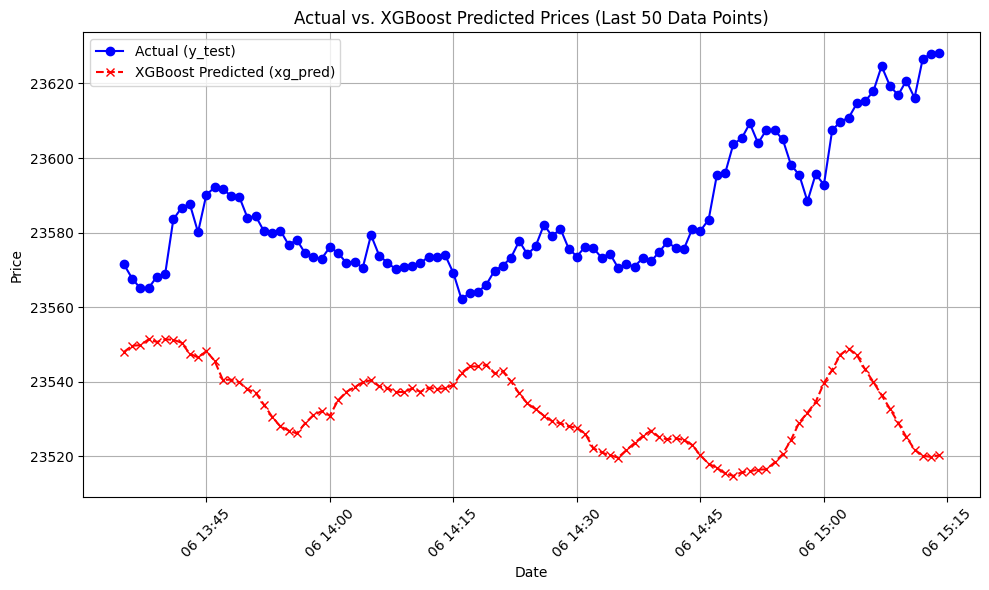

In [34]:

number = 100
# Select the last 50 data points
y_test_last_50 = y_test[-number:]
xg_pred_last_50 = predictions_original[-number:]

# Plot y_test vs xg_pred for the last 50 points
plt.figure(figsize=(10, 6))
plt.plot(y_test_last_50.index, y_test_last_50, label='Actual (y_test)', marker='o', linestyle='-', color='blue')
plt.plot(y_test_last_50.index, xg_pred_last_50, label='XGBoost Predicted (xg_pred)', marker='x', linestyle='--', color='red')
plt.title('Actual vs. XGBoost Predicted Prices (Last 50 Data Points)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation

## Classification Metrics

In [ ]:
def calculate_classification_metrics(y_true, y_pred, threshold=0.001):
    """
    Calculate classification metrics for price prediction
    threshold: minimum price change to consider as significant movement
    """
    # Convert regression predictions to classification
    y_true_class = (y_true > threshold).astype(int)
    y_pred_class = (y_pred > threshold).astype(int)

    accuracy = accuracy_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class, average='weighted', zero_division=0)
    recall = recall_score(y_true_class, y_pred_class, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

def print_classification_metrics(models_predictions, y_test, model_names):
    """Print classification metrics for all models"""
    print("\n" + "="*60)
    print("CLASSIFICATION METRICS")
    print("="*60)

    for i, (pred, name) in enumerate(zip(models_predictions, model_names)):
        metrics = calculate_classification_metrics(y_test, pred)
        print(f"\n{name} Model:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")


## Portfolio Metrics

In [ ]:
def calculate_portfolio_metrics(returns, risk_free_rate=0.02):
    """
    Calculate comprehensive portfolio performance metrics
    """
    returns_series = pd.Series(returns)

    # Calculate cumulative returns
    cumulative_returns = (1 + returns_series).cumprod()

    # CAGR (Compound Annual Growth Rate)
    total_return = cumulative_returns.iloc[-1]
    n_years = len(returns_series) / (252 * 390)  # 390 minutes per trading day
    cagr = (total_return ** (1/n_years)) - 1 if n_years > 0 else 0

    # Sharpe Ratio
    excess_returns = returns_series - risk_free_rate/252/390  # Convert annual to minute
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252 * 390) if excess_returns.std() != 0 else 0

    # Maximum Drawdown
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns / peak) - 1
    max_drawdown = drawdown.min()

    # Sortino Ratio (downside deviation)
    downside_returns = returns_series[returns_series < 0]
    downside_std = downside_returns.std() if len(downside_returns) > 0 else 0
    sortino_ratio = excess_returns.mean() / downside_std * np.sqrt(252 * 390) if downside_std != 0 else 0

    # Calmar Ratio
    calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else 0

    return {
        'cagr': cagr,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'sortino_ratio': sortino_ratio,
        'calmar_ratio': calmar_ratio,
        'total_return': total_return - 1,
        'volatility': returns_series.std() * np.sqrt(252 * 390)
    }

def simulate_trading_returns(predictions, actual_prices, transaction_cost=0.001):
    """
    Simulate trading returns based on predictions
    """
    returns = []
    positions = []

    for i in range(1, len(predictions)):
        # Simple strategy: buy if predicted increase > threshold
        if predictions[i] > predictions[i-1] * 1.002:  # 0.2% threshold
            position = 1  # Long
        elif predictions[i] < predictions[i-1] * 0.998:  # -0.2% threshold
            position = -1  # Short
        else:
            position = 0  # Hold

        positions.append(position)

        # Calculate return
        actual_return = (actual_prices[i] - actual_prices[i-1]) / actual_prices[i-1]
        strategy_return = position * actual_return - abs(position) * transaction_cost
        returns.append(strategy_return)

    return returns, positions

def print_portfolio_metrics(models_predictions, actual_prices, model_names):
    """Print portfolio metrics for all models"""
    print("\n" + "="*60)
    print("PORTFOLIO METRICS")
    print("="*60)

    for pred, name in zip(models_predictions, model_names):
        returns, positions = simulate_trading_returns(pred, actual_prices)
        metrics = calculate_portfolio_metrics(returns)

        print(f"\n{name} Model:")
        print(f"  CAGR:           {metrics['cagr']:.4f} ({metrics['cagr']*100:.2f}%)")
        print(f"  Sharpe Ratio:   {metrics['sharpe_ratio']:.4f}")
        print(f"  Max Drawdown:   {metrics['max_drawdown']:.4f} ({metrics['max_drawdown']*100:.2f}%)")
        print(f"  Sortino Ratio:  {metrics['sortino_ratio']:.4f}")
        print(f"  Calmar Ratio:   {metrics['calmar_ratio']:.4f}")
        print(f"  Total Return:   {metrics['total_return']:.4f} ({metrics['total_return']*100:.2f}%)")
        print(f"  Volatility:     {metrics['volatility']:.4f} ({metrics['volatility']*100:.2f}%)")


## Operational Metrics

In [ ]:
def calculate_operational_metrics(positions, returns, actual_prices):
    """
    Calculate operational trading metrics
    """
    # Trade hit ratio
    winning_trades = sum(1 for r in returns if r > 0)
    total_trades = sum(1 for p in positions if p != 0)
    hit_ratio = winning_trades / total_trades if total_trades > 0 else 0

    # Turnover (how often positions change)
    position_changes = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i-1])
    turnover = position_changes / len(positions) if len(positions) > 0 else 0

    # Average holding period
    holding_periods = []
    current_hold = 0

    for i in range(len(positions)):
        if positions[i] != 0:
            current_hold += 1
        else:
            if current_hold > 0:
                holding_periods.append(current_hold)
                current_hold = 0

    if current_hold > 0:
        holding_periods.append(current_hold)

    avg_holding_period = np.mean(holding_periods) if holding_periods else 0

    # Additional metrics
    avg_win = np.mean([r for r in returns if r > 0]) if any(r > 0 for r in returns) else 0
    avg_loss = np.mean([r for r in returns if r < 0]) if any(r < 0 for r in returns) else 0
    profit_factor = abs(sum(r for r in returns if r > 0) / sum(r for r in returns if r < 0)) if sum(r for r in returns if r < 0) != 0 else float('inf')

    return {
        'hit_ratio': hit_ratio,
        'turnover': turnover,
        'avg_holding_period': avg_holding_period,
        'total_trades': total_trades,
        'winning_trades': winning_trades,
        'losing_trades': total_trades - winning_trades,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'profit_factor': profit_factor
    }

def print_operational_metrics(models_predictions, actual_prices, model_names):
    """Print operational metrics for all models"""
    print("\n" + "="*60)
    print("OPERATIONAL METRICS")
    print("="*60)

    for pred, name in zip(models_predictions, model_names):
        returns, positions = simulate_trading_returns(pred, actual_prices)
        metrics = calculate_operational_metrics(positions, returns, actual_prices)

        print(f"\n{name} Model:")
        print(f"  Trade Hit Ratio:      {metrics['hit_ratio']:.4f} ({metrics['hit_ratio']*100:.2f}%)")
        print(f"  Turnover:             {metrics['turnover']:.4f}")
        print(f"  Avg Holding Period:   {metrics['avg_holding_period']:.2f} minutes")
        print(f"  Total Trades:         {metrics['total_trades']}")
        print(f"  Winning Trades:       {metrics['winning_trades']}")
        print(f"  Losing Trades:        {metrics['losing_trades']}")
        print(f"  Average Win:          {metrics['avg_win']:.6f} ({metrics['avg_win']*100:.4f}%)")
        print(f"  Average Loss:         {metrics['avg_loss']:.6f} ({metrics['avg_loss']*100:.4f}%)")
        print(f"  Profit Factor:        {metrics['profit_factor']:.4f}")


## Evaluation PipeLine

In [ ]:
actual_prices = df_processed['Close']
actual_prices = actual_prices[int((0.8 * len(df_processed))):]
len(actual_prices)

37100

In [ ]:
def comprehensive_model_evaluation(models_predictions, actual_prices, y_test, model_names):
    """
    Run complete evaluation pipeline for all models
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL EVALUATION REPORT")
    print("="*80)

    # Print all metrics
    print_classification_metrics(models_predictions, y_test, model_names)
    print_portfolio_metrics(models_predictions, actual_prices, model_names)
    print_operational_metrics(models_predictions, actual_prices, model_names)

    # Summary comparison table
    print("\n" + "="*60)
    print("SUMMARY COMPARISON TABLE")
    print("="*60)

    summary_data = []
    for pred, name in zip(models_predictions, model_names):
        returns, positions = simulate_trading_returns(pred, actual_prices)
        portfolio_metrics = calculate_portfolio_metrics(returns)
        operational_metrics = calculate_operational_metrics(positions, returns, actual_prices)
        classification_metrics = calculate_classification_metrics(y_test, pred)

        summary_data.append({
            'Model': name,
            'Accuracy': f"{classification_metrics['accuracy']:.4f}",
            'Sharpe': f"{portfolio_metrics['sharpe_ratio']:.4f}",
            'CAGR': f"{portfolio_metrics['cagr']*100:.2f}%",
            'Max DD': f"{portfolio_metrics['max_drawdown']*100:.2f}%",
            'Hit Ratio': f"{operational_metrics['hit_ratio']*100:.2f}%",
            'Trades': operational_metrics['total_trades']
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

# Usage example
model_names = ['Random Forest' , 'XG Boost']
models_predictions = [rf_pred , xg_pred]

# Run comprehensive evaluation
comprehensive_model_evaluation(models_predictions, actual_prices, y_test, model_names)



COMPREHENSIVE MODEL EVALUATION REPORT

CLASSIFICATION METRICS

Random Forest Model:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000

XG Boost Model:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000

PORTFOLIO METRICS

Random Forest Model:
  CAGR:           0.0600 (6.00%)
  Sharpe Ratio:   0.8170
  Max Drawdown:   -0.0522 (-5.22%)
  Sortino Ratio:  0.1807
  Calmar Ratio:   1.1493
  Total Return:   0.0222 (2.22%)
  Volatility:     0.0483 (4.83%)

XG Boost Model:
  CAGR:           -0.9750 (-97.50%)
  Sharpe Ratio:   -45.1768
  Max Drawdown:   -0.7515 (-75.15%)
  Sortino Ratio:  -18.1180
  Calmar Ratio:   -1.2974
  Total Return:   -0.7515 (-75.15%)
  Volatility:     0.0820 (8.20%)

OPERATIONAL METRICS

Random Forest Model:
  Trade Hit Ratio:      0.3333 (33.33%)
  Turnover:             0.0065
  Avg Holding Period:   1.22 minutes
  Total Trades:         141
  Winning Trades:       47
  Losing Trades:        94
  Average Win:          0.002565 (0.2565%)
  Average Loss